# **In Class Assignment: Sentiment Analysis**

## Name: Dallin Moore
## *DATA 5420/6420*

In this in-class assignment we will examine the sentiment of movie reviews using both unsupervised lexicon-based modeling and through supervised classification. We will then leverage tools to interpret the decision of our sentiment analysis model to determine the words and topics associated with positive and negative sentiments.

We begin, as always, be importing our dependencies:

In [17]:
import pandas as pd
import numpy as np
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')

import sklearn
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=2, linewidth=80)

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Let's examine the vader dictionary a bit. What do these scores represent, and how are they interpreted?**

The output below shows specific words and their associated score. The score has zero as neutral and it's magnitude in the positive/negative direction relate to the positive/negative sentiment that the word has.

In [18]:
sid = SentimentIntensityAnalyzer()
vader_lexicon = sid.lexicon

# Display a preview of the lexicon
dict(list(vader_lexicon.items())[1000:1035])

{'beauties': 2.4,
 'beautification': 1.9,
 'beautifications': 2.4,
 'beautified': 2.1,
 'beautifier': 1.7,
 'beautifiers': 1.7,
 'beautifies': 1.8,
 'beautiful': 2.9,
 'beautifuler': 2.1,
 'beautifulest': 2.6,
 'beautifully': 2.7,
 'beautifulness': 2.6,
 'beautify': 2.3,
 'beautifying': 2.3,
 'beauts': 1.7,
 'beauty': 2.8,
 'belittle': -1.9,
 'belittled': -2.0,
 'beloved': 2.3,
 'benefic': 1.4,
 'benefice': 0.4,
 'beneficed': 1.1,
 'beneficence': 2.8,
 'beneficences': 1.5,
 'beneficent': 2.3,
 'beneficently': 2.2,
 'benefices': 1.1,
 'beneficial': 1.9,
 'beneficially': 2.4,
 'beneficialness': 1.7,
 'beneficiaries': 1.8,
 'beneficiary': 2.1,
 'beneficiate': 1.0,
 'beneficiation': 0.4,
 'benefit': 2.0}

## **Load and Normalize the Dataset**

In [19]:
df = pd.read_csv('/content/movie_reviews-1.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


positive    25000
negative    25000
Name: sentiment, dtype: int64

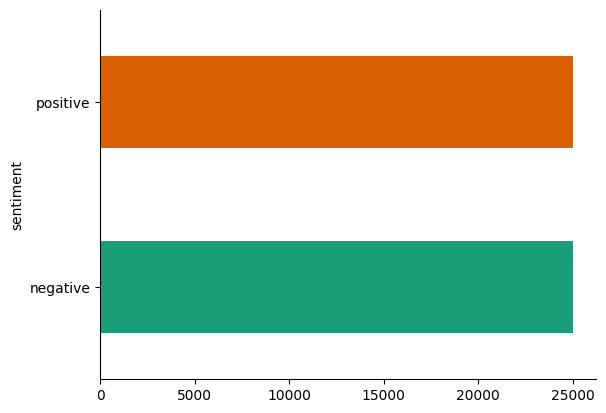

In [20]:
# @title Sentiment Distribution

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
df['sentiment'].value_counts()

In [ ]:
def clean_text(text):
    text = text.lower() # lowercase
    text = re.sub(r'\d+', '', text) # substituting digits with nothing
    text = re.sub(r'[^\w\s]', '', text) # removes anything that isn't a-z character
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    text = ' '.join(tokens)                                                                   # which typical normalization step did we skip? Lemmatization
    return text

df['clean_review'] = df['review'].apply(clean_text)
df.head()

In [24]:
df = pd.read_csv('/content/cleaned_movies.csv')
df.head()

,Unnamed: 0,review,sentiment,clean_review
0,0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode yo...
1,1,A wonderful little production. <br /><br />The...,positive,wonderful little production br br filming tech...
2,2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...
4,4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [25]:
 reviews = np.array(df['clean_review'])
sentiments = np.array(df['sentiment'])

test_reviews = reviews[9500:]
test_sentiments = sentiments[9500:]
sample_review_ids = [9511,9622,9880]

## **Sentiment Analysis with VADER**
### Create a Scoring Function:

In [26]:
# Add in comments
def analyze_sentiment_vader_lexicon(review,
                                    threshold=0.1,
                                    verbose=False): # for additional stats
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review) # score the words

    agg_score = scores['compound'] # overall score
    final_sentiment = 'positive' if agg_score >= threshold\
                                   else 'negative'
    if verbose:
        positive = str(round(scores['pos'], 2)*100)+'%' # percent of words positive
        final = round(agg_score, 2)
        negative = str(round(scores['neg'], 2)*100)+'%'
        neutral = str(round(scores['neu'], 2)*100)+'%'
        sentiment_frame = pd.DataFrame([[final_sentiment, final, positive,
                                        negative, neutral]],
                                        columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'],
                                                                      ['Predicted Sentiment', 'Polarity Score',
                                                                       'Positive', 'Negative', 'Neutral']],
                                                              codes=[[0,0,0,0,0],[0,1,2,3,4]]))
        print(sentiment_frame)

    return final_sentiment


### Predict Sentiment of Sample Reviews

In [27]:
for reviews, sentiments in zip(reviews[sample_review_ids], sentiments[sample_review_ids]):
    print('REVIEW:', reviews)
    print('Actual Sentiment:', sentiments)
    pred = analyze_sentiment_vader_lexicon(reviews, threshold = 0.4, verbose = True)
    print('-'*60)

REVIEW: scientists behaved way hg wells confident would future history wouldnt quite turned way things come almost years past point wells wrote shape things come film based closer world describes ways farther awaybr br though well known players raymond massey ralph richardson cedric hardwicke cast theyre caricatures real characters main weakness film devoted wellss philosophy science solve problems rest us backward foolsbr br masseys characters two generations family holds supremely optimistic view cedric hardwicke skeptic feels man rushing far forward ralph richardson warlord arisen destruction another thirty years war fought modern weapons way atomic bomb invented poison gas deemed weapon almost destroys mankindbr br according wells science conquest never mix scientists group far world politics engage things wellss lifetime scientists certainly fled rightwing fascistic governments hitler mussolini folks however order defeat subordinated allies fashioned atomic weapons ushered modern 

In [30]:
df['review'].loc[9880]

"I always loved this film. The music,story and the action. I especially love the opening and closing of the film. The music stayed with me throughout the years. The WWI plane battles were great and the comedy is typical Blake Edwards. Slaptick is his forte' after all. Julie's singing is amazing and keeps me glued to the screen. The sets and the scenes are wonderful. The characters are appealing. I loved the scene with the wounded soldiers and Julie's singing to them. I wish she sang to me in Vietnam. I also enjoyed the old cars from the period and the WWI music.I was glad when the DVD arrived. Now I can whistle in the dark watching it again and again."

**What impact does the threshold value have on the classification of sentiments within reviews?**

How strong of a sentiment score is needed to classify the text as positive. The closer it is to -3 (for this specific model), the lower the positive sentiment needs to be for it to be classified as such.

**Do you agree with all of the ratings? If not, what words or phrases might be throwing off the sentiment score?**

not necessarily. The high amount of neutral words is causing for lower scores. I think that for this dataset specifically there is less indication of positive or negative sentiment. I was surprised rating 9622 was correctly classified because of the sarcasm present (it starts by saying it was a good movie), and rating 9511 is harder to identify by looking at it, but it also seems positive. Rating 9880 was by far the most positive case (with an unsurprising score of .99).

## **Next let's predict sentiment via machine learning, using several classification algorithms...**

### Build a training and test set

### Feature Engineering

In [32]:
x = df['clean_review']
y = df['sentiment']

train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(x, y, test_size=0.2,random_state=42)
                                                        # consider unigrams and bigrams (one and two word phrases)
tv = TfidfVectorizer(use_idf=True, min_df=5, max_df=0.6, ngram_range=(1,2), sublinear_tf=True)
tv_train_features = tv.fit_transform(train_reviews)
tv_test_features = tv.transform(test_reviews)

tv_train_features.shape, tv_test_features.shape

((8000, 30582), (2000, 30582))

### Model Training, Prediction, and Performance Eval

In [33]:
lr = LogisticRegression(penalty='l2', max_iter=100, C=1) # linear model
svm = SGDClassifier(loss='hinge', max_iter=100)          # and non-linear

#### Logistic Regression with TF-IDF Features

In [34]:
def train_predict_model(classifier,
                        train_features, train_labels,
                        test_features, test_labels):
    classifier.fit(train_features, train_labels)
    predictions = classifier.predict(test_features)
    return predictions

In [36]:
lr_tfidf_predictions = train_predict_model(classifier=lr,
                                           train_features=tv_train_features, train_labels=train_sentiments,
                                           test_features=tv_test_features, test_labels=test_sentiments)

print(classification_report(test_sentiments, lr_tfidf_predictions))

              precision    recall  f1-score   support

    negative       0.91      0.87      0.89       996
    positive       0.87      0.91      0.89      1004

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [38]:
svm_tfidf_predictions = train_predict_model(classifier=svm,
                                               train_features=tv_train_features, train_labels=train_sentiments,
                                               test_features=tv_test_features, test_labels=test_sentiments)

print(classification_report(test_sentiments, svm_tfidf_predictions))

              precision    recall  f1-score   support

    negative       0.90      0.86      0.88       996
    positive       0.87      0.90      0.89      1004

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



**Which metric would be most appropriate to use in this case and why?**

The linear regression model was slightly more accurate for both precision and recall and therefor should be used. In this case, since we don't know the use case or whethere false-positives or false-negatives are more costly, simply looking at the f1-scores reveals which model is better (although using recall/precision would give the same result).

## **Interpretation Time!**

First let's examine predicted probabilities to see how confident our model was in its predictions...

In [39]:
model = lr.fit(tv_train_features, train_sentiments)

In [40]:
predicted_probas = list(zip(*model.predict_proba(tv_test_features)))[0]

In [41]:
predictions_df = pd.DataFrame()
predictions_df['Reviews'] = test_reviews
predictions_df['True Sentiment'] = test_sentiments
predictions_df['Predicted Sentiment'] = lr_tfidf_predictions
predictions_df['Probability_Negative'] = predicted_probas

In [42]:
predictions_df

,Reviews,True Sentiment,Predicted Sentiment,Probability_Negative
6252,pretty pointless remake starting opening title...,negative,negative,0.777969
4684,agree comments regarding downward spin last vi...,negative,positive,0.444922
1731,picked movie intention getting bad zombie movi...,negative,negative,0.878582
4742,thought movie lol funny fun taken seriously mo...,positive,positive,0.166426
4521,interesting study societal sexuality well dark...,positive,positive,0.258018
...,...,...,...,...
6412,wizards lost kingdom movie young prince simon ...,positive,negative,0.864867
8285,much love darling little comedy anyone ever bu...,positive,positive,0.079716
7853,strong woman oriented subject long director kr...,positive,positive,0.193285
1095,immoral reprehensible piece garbage doubt want...,negative,negative,0.796857


**Sort the predictions_df by predicted probability to find movies with high, moderate and low probabilities to examine a) whether the predictions were correct and b) try to identify what sorts of words or phrases led to high or low probabilities of a negative sentiment**

At the top and bottom of the spectrum the model was really accurate at prediciting positive/negative. However, in the middle it was less accurate and even as a human reading the text it is somewhat difficult to tell whether the prediction is positve or negative (it's not black and white).

The word 'love' seems very powerful indicater of positive sentiment.

Looking at rating 9186, the model was not very certain that it was positive (0.458 probability negative) but as a reader it was very clearly negative because it ended saying the movie 'severely disappoints.' I don't know where the positive sentiment came from in this case, perhaps it was just mostly neutral.

## **Feature Importance Plot**:

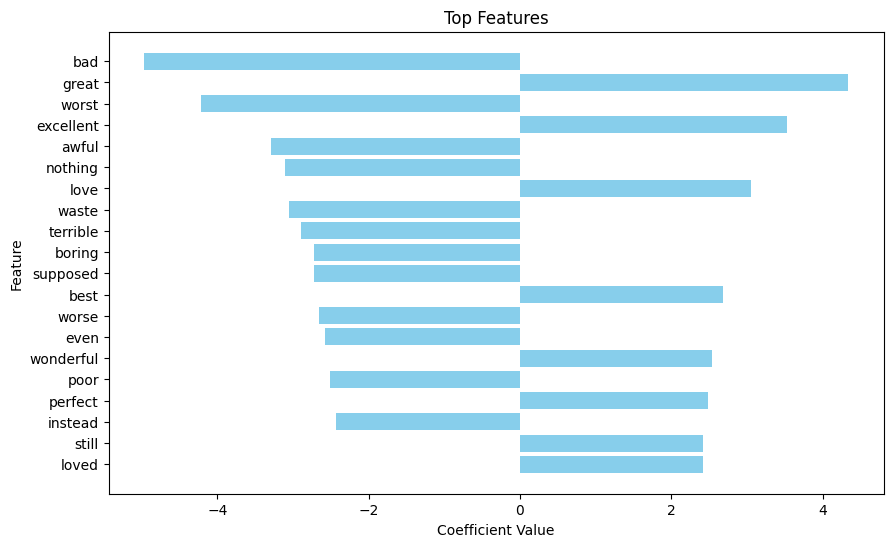

In [43]:
# Add in comments
def plot_top_feature_importance_updated(coefficients, feature_names, title, top_n=20):
    """Helper function to plot top feature importance using only matplotlib"""
    coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
    coef_df = coef_df.reindex(coef_df.coefficient.abs().sort_values(ascending=False).index)

    plt.figure(figsize=(10, 6))

# use matplotlib to create a bar chart to display the topp features and their coefficients from the lr

    top_features = coef_df.head(top_n)
    plt.barh(top_features['feature'], top_features['coefficient'], align='center', color='skyblue')
    plt.title(title)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.gca().invert_yaxis()
    plt.show()

# only use 5000 observations
subset_size = 5000
subset_reviews = train_reviews[:subset_size]
subset_sentiments = train_sentiments[:subset_size]

tv = TfidfVectorizer(use_idf=True, min_df=5, max_df=0.6, ngram_range=(1,2),
                     sublinear_tf=True, max_features=5000)
tv_train_features_subset = tv.fit_transform(subset_reviews)

# rerun lr on subset

lr = LogisticRegression(max_iter=1000)
lr.fit(tv_train_features_subset, subset_sentiments)

# extract the sentiment
predicted_sentiments_subset = lr.predict(tv_train_features_subset)

# extract the coefficients and the vocab name
coefficients_subset = lr.coef_[0]
feature_names_subset = tv.get_feature_names_out()




plot_top_feature_importance_updated(coefficients_subset,feature_names_subset, 'Top Features', top_n=20)

## **Apply to unlabeled data:**

In [51]:
# Toy sample movie reviews
sample_reviews = [
    "The film was a masterpiece, with brilliant acting and a captivating storyline.",
    "I didn't enjoy the movie at all. The plot was dull and the characters were uninteresting.",
    "A decent watch. Some parts were great, while others were just okay.",
    "Absolutely loved it! The cinematography was top-notch and the performances were unforgettable.",
    "It felt like a waste of time. The jokes were flat and the pacing was off.",
    "What a waste of my time! It was worse than I thought it would be but my wife loved it.",
    "It was nothing special. I'll only watch it again if I had to.",
    "This movie is different. I've never stayed so engaged during a movie!",
    "It was definitely interesting. I'm curious if it will get a sequel, it couldn't be worse than this!"
]

# Clean the sample reviews
cleaned_sample_reviews = [clean_text(review) for review in sample_reviews]

# Transform the cleaned reviews using the previously trained TF-IDF vectorizer
tv_sample_features = tv.transform(cleaned_sample_reviews)

# Predict sentiments using the trained logistic regression model
predicted_sample_sentiments = lr.predict(tv_sample_features)

predicted_sample_sentiments

array(['positive', 'negative', 'positive', 'positive', 'negative', 'negative',
       'negative', 'positive', 'negative'], dtype=object)

## [Hugging Face](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment) Pretrained Models**

In [45]:
!pip install transformers

In [52]:
from transformers import pipeline

classifier = pipeline('sentiment-analysis')
results = classifier(sample_reviews)


for review, result in zip(sample_reviews, results):
    print(f"Review: {review}\nSentiment: {result['label']} (Confidence: {result['score']:.4f})\n")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Review: The film was a masterpiece, with brilliant acting and a captivating storyline.
Sentiment: POSITIVE (Confidence: 0.9999)

Review: I didn't enjoy the movie at all. The plot was dull and the characters were uninteresting.
Sentiment: NEGATIVE (Confidence: 0.9998)

Review: A decent watch. Some parts were great, while others were just okay.
Sentiment: POSITIVE (Confidence: 0.9998)

Review: Absolutely loved it! The cinematography was top-notch and the performances were unforgettable.
Sentiment: POSITIVE (Confidence: 0.9999)

Review: It felt like a waste of time. The jokes were flat and the pacing was off.
Sentiment: NEGATIVE (Confidence: 0.9998)

Review: What a waste of my time! It was worse than I thought it would be but my wife loved it.
Sentiment: POSITIVE (Confidence: 0.9916)

Review: It was nothing special. I'll only watch it again if I had to.
Sentiment: NEGATIVE (Confidence: 0.9978)

Review: This movie is different. I've never stayed so engaged during a movie!
Sentiment: POSITI

I added some to try to stump the models and ours classified my last one  correctly while the huggingface model did not.

In [53]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import torch

# Add comments

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name) # tokenization

inputs = tokenizer(sample_reviews, return_tensors="pt", padding=True, truncation=True, max_length=512)
with torch.no_grad():
    outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=-1) # calculate the probability
    predicted_classes = torch.argmax(probs, dim=-1)

for review, pred_class in zip(sample_reviews, predicted_classes): # for each review, print out and the review
    print(f"Review: {review}\nSentiment Score: {pred_class.item() + 1}\n")

Review: The film was a masterpiece, with brilliant acting and a captivating storyline.
Sentiment Score: 5

Review: I didn't enjoy the movie at all. The plot was dull and the characters were uninteresting.
Sentiment Score: 1

Review: A decent watch. Some parts were great, while others were just okay.
Sentiment Score: 3

Review: Absolutely loved it! The cinematography was top-notch and the performances were unforgettable.
Sentiment Score: 5

Review: It felt like a waste of time. The jokes were flat and the pacing was off.
Sentiment Score: 1

Review: What a waste of my time! It was worse than I thought it would be but my wife loved it.
Sentiment Score: 1

Review: It was nothing special. I'll only watch it again if I had to.
Sentiment Score: 3

Review: This movie is different. I've never stayed so engaged during a movie!
Sentiment Score: 1

Review: It was definitely interesting. I'm curious if it will get a sequel, it couldn't be worse than this!
Sentiment Score: 4

